# Project: Dog vs Cat Classification

In [34]:
from pathlib import Path
import os
import torch
from torch import nn

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [36]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [37]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (377, 500, 3)')

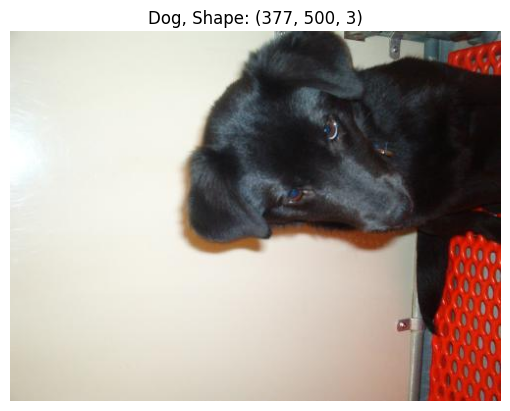

In [38]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [39]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [40]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [41]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.8078, 0.8353, 0.8549,  ..., 0.1922, 0.2745, 0.3647],
         [0.8275, 0.8471, 0.8588,  ..., 0.2314, 0.2941, 0.4314],
         [0.8431, 0.8588, 0.8627,  ..., 0.4784, 0.5608, 0.6392],
         ...,
         [0.8000, 0.8039, 0.8118,  ..., 0.7451, 0.6863, 0.7059],
         [0.7882, 0.8000, 0.8039,  ..., 0.6392, 0.7333, 0.7294],
         [0.7765, 0.7922, 0.8000,  ..., 0.6157, 0.6706, 0.5961]],

        [[0.8157, 0.8431, 0.8627,  ..., 0.2157, 0.3333, 0.4078],
         [0.8353, 0.8549, 0.8667,  ..., 0.2431, 0.2667, 0.3216],
         [0.8510, 0.8667, 0.8706,  ..., 0.1765, 0.1490, 0.1490],
         ...,
         [0.7725, 0.7765, 0.7843,  ..., 0.1176, 0.1961, 0.1176],
         [0.7608, 0.7725, 0.7765,  ..., 0.1843, 0.1216, 0.1137],
         [0.7490, 0.7647, 0.7725,  ..., 0.2314, 0.1451, 0.1529]],

        [[0.7647, 0.7922, 0.8118,  ..., 0.2196, 0.3490, 0.4157],
         [0.7843, 0.8039, 0.8157,  ..., 0.2431, 0.2706, 0.3059],
         [0.8000, 0.8157, 0.8196,  ..., 0.1412, 0.1020, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

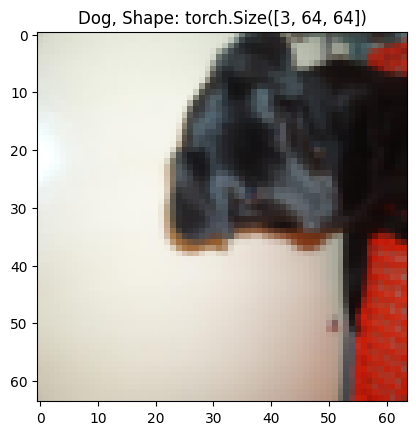

In [42]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [43]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 321
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 82
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [44]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [45]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [46]:
len(train_data), len(test_data)

(321, 82)

# Turn loaded images into 'DataLoader'

In [47]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x22141730d60>,
 <torch.utils.data.dataloader.DataLoader at 0x22135bf7610>)

In [48]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [49]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [50]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [51]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [52]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[-0.1116],
        [-0.1272],
        [-0.1263],
        [-0.1157],
        [-0.1202],
        [-0.1262],
        [-0.1235],
        [-0.1208],
        [-0.1113],
        [-0.1195],
        [-0.1180],
        [-0.1300],
        [-0.1119],
        [-0.1203],
        [-0.0991],
        [-0.1239],
        [-0.1289],
        [-0.1151],
        [-0.1379],
        [-0.1167],
        [-0.1381],
        [-0.1142],
        [-0.1183],
        [-0.1041],
        [-0.1289],
        [-0.1381],
        [-0.1219],
        [-0.1233],
        [-0.1331],
        [-0.1102],
        [-0.1170],
        [-0.1181]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [53]:
from tqdm import tqdm
import time

In [54]:
epochs = 5

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

Epoch: 0 | Train Loss: 0.6912, Train Accuracy: 56.25 | Test Loss: 0.6855996251106262, Test Accuracy: 57.291666666666664


 40%|████      | 2/5 [00:02<00:03,  1.27s/it]

Epoch: 1 | Train Loss: 0.6935, Train Accuracy: 54.55 | Test Loss: 0.6850398580233256, Test Accuracy: 57.291666666666664


 60%|██████    | 3/5 [00:03<00:02,  1.03s/it]

Epoch: 2 | Train Loss: 0.7034, Train Accuracy: 45.74 | Test Loss: 0.6860594550768534, Test Accuracy: 57.291666666666664


 80%|████████  | 4/5 [00:04<00:00,  1.08it/s]

Epoch: 3 | Train Loss: 0.6935, Train Accuracy: 51.14 | Test Loss: 0.6998258233070374, Test Accuracy: 42.70833333333333


100%|██████████| 5/5 [00:05<00:00,  1.00s/it]

Epoch: 4 | Train Loss: 0.6932, Train Accuracy: 45.45 | Test Loss: 0.6914219657580057, Test Accuracy: 55.67129629629629
Total time: 5.023708820343018


# Plot model_0 results

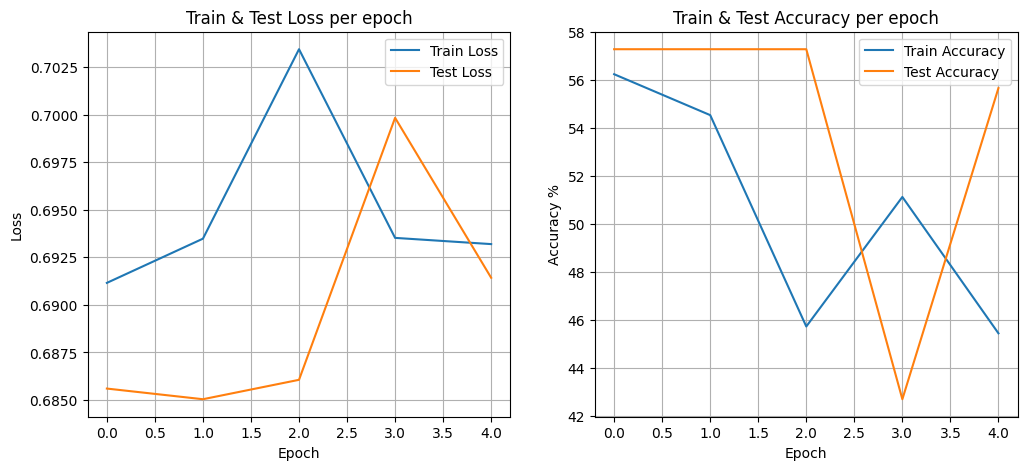

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [56]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

5 5
5 5


In [57]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [58]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [59]:
train_data_transform_augmentation = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [60]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 321
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 82
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ))

In [61]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x221418f2c70>,
 <torch.utils.data.dataloader.DataLoader at 0x221418f2be0>)

In [62]:
len(class_names)

2

In [63]:
model_1 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [64]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [65]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:00<00:42,  1.15it/s]

Epoch: 0 | Train Loss: 0.6958, Train Accuracy: 46.73 | Test Loss: 0.6927497982978821, Test Accuracy: 48.78048780487805


  4%|▍         | 2/50 [00:01<00:42,  1.13it/s]

Epoch: 1 | Train Loss: 0.6955, Train Accuracy: 51.09 | Test Loss: 0.6930018067359924, Test Accuracy: 50.0


  6%|▌         | 3/50 [00:02<00:41,  1.13it/s]

Epoch: 2 | Train Loss: 0.6966, Train Accuracy: 50.78 | Test Loss: 0.6879659096399943, Test Accuracy: 50.0


  8%|▊         | 4/50 [00:03<00:40,  1.13it/s]

Epoch: 3 | Train Loss: 0.6926, Train Accuracy: 52.96 | Test Loss: 0.6895086963971456, Test Accuracy: 52.4390243902439


 10%|█         | 5/50 [00:04<00:39,  1.13it/s]

Epoch: 4 | Train Loss: 0.6982, Train Accuracy: 52.34 | Test Loss: 0.6871453126271566, Test Accuracy: 54.87804878048781


 12%|█▏        | 6/50 [00:05<00:38,  1.13it/s]

Epoch: 5 | Train Loss: 0.6904, Train Accuracy: 57.94 | Test Loss: 0.6940027872721354, Test Accuracy: 51.21951219512195


 14%|█▍        | 7/50 [00:06<00:37,  1.15it/s]

Epoch: 6 | Train Loss: 0.6877, Train Accuracy: 50.16 | Test Loss: 0.6981247464815775, Test Accuracy: 50.0


 16%|█▌        | 8/50 [00:07<00:39,  1.07it/s]

Epoch: 7 | Train Loss: 0.6978, Train Accuracy: 49.84 | Test Loss: 0.6949493885040283, Test Accuracy: 52.4390243902439


 18%|█▊        | 9/50 [00:08<00:40,  1.01it/s]

Epoch: 8 | Train Loss: 0.6929, Train Accuracy: 49.22 | Test Loss: 0.6935485998789469, Test Accuracy: 42.68292682926829


 20%|██        | 10/50 [00:09<00:40,  1.00s/it]

Epoch: 9 | Train Loss: 0.6952, Train Accuracy: 51.71 | Test Loss: 0.6935269633928934, Test Accuracy: 52.4390243902439


 22%|██▏       | 11/50 [00:10<00:39,  1.01s/it]

Epoch: 10 | Train Loss: 0.6914, Train Accuracy: 49.53 | Test Loss: 0.6958740949630737, Test Accuracy: 50.0


 24%|██▍       | 12/50 [00:11<00:38,  1.02s/it]

Epoch: 11 | Train Loss: 0.6884, Train Accuracy: 49.84 | Test Loss: 0.6989760597546896, Test Accuracy: 50.0


 26%|██▌       | 13/50 [00:12<00:38,  1.03s/it]

Epoch: 12 | Train Loss: 0.6883, Train Accuracy: 49.53 | Test Loss: 0.6977863113085429, Test Accuracy: 50.0


 28%|██▊       | 14/50 [00:13<00:37,  1.05s/it]

Epoch: 13 | Train Loss: 0.7000, Train Accuracy: 50.47 | Test Loss: 0.6941137512524923, Test Accuracy: 57.3170731707317


 30%|███       | 15/50 [00:14<00:37,  1.06s/it]

Epoch: 14 | Train Loss: 0.6806, Train Accuracy: 58.57 | Test Loss: 0.6840195655822754, Test Accuracy: 46.34146341463415


 32%|███▏      | 16/50 [00:15<00:36,  1.08s/it]

Epoch: 15 | Train Loss: 0.6838, Train Accuracy: 51.09 | Test Loss: 0.6825740138689677, Test Accuracy: 50.0


 34%|███▍      | 17/50 [00:16<00:33,  1.01s/it]

Epoch: 16 | Train Loss: 0.6898, Train Accuracy: 55.45 | Test Loss: 0.6844550569852194, Test Accuracy: 45.1219512195122


 36%|███▌      | 18/50 [00:17<00:31,  1.02it/s]

Epoch: 17 | Train Loss: 0.6838, Train Accuracy: 58.57 | Test Loss: 0.6822471022605896, Test Accuracy: 51.21951219512195


 38%|███▊      | 19/50 [00:18<00:30,  1.00it/s]

Epoch: 18 | Train Loss: 0.7069, Train Accuracy: 61.37 | Test Loss: 0.6780702074368795, Test Accuracy: 48.78048780487805


 40%|████      | 20/50 [00:19<00:30,  1.02s/it]

Epoch: 19 | Train Loss: 0.6882, Train Accuracy: 55.76 | Test Loss: 0.694914698600769, Test Accuracy: 54.87804878048781


 42%|████▏     | 21/50 [00:20<00:29,  1.02s/it]

Epoch: 20 | Train Loss: 0.6752, Train Accuracy: 58.26 | Test Loss: 0.6922030647595724, Test Accuracy: 51.21951219512195


 44%|████▍     | 22/50 [00:21<00:28,  1.02s/it]

Epoch: 21 | Train Loss: 0.6948, Train Accuracy: 57.94 | Test Loss: 0.6906052033106486, Test Accuracy: 54.87804878048781


 46%|████▌     | 23/50 [00:22<00:27,  1.02s/it]

Epoch: 22 | Train Loss: 0.6755, Train Accuracy: 63.55 | Test Loss: 0.6789051095644633, Test Accuracy: 48.78048780487805


 48%|████▊     | 24/50 [00:23<00:26,  1.02s/it]

Epoch: 23 | Train Loss: 0.6845, Train Accuracy: 61.37 | Test Loss: 0.679510772228241, Test Accuracy: 52.4390243902439


 50%|█████     | 25/50 [00:24<00:25,  1.02s/it]

Epoch: 24 | Train Loss: 0.6640, Train Accuracy: 60.75 | Test Loss: 0.6681380470593771, Test Accuracy: 54.87804878048781


 52%|█████▏    | 26/50 [00:25<00:23,  1.01it/s]

Epoch: 25 | Train Loss: 0.6557, Train Accuracy: 59.50 | Test Loss: 0.6809409856796265, Test Accuracy: 54.87804878048781


 54%|█████▍    | 27/50 [00:26<00:21,  1.06it/s]

Epoch: 26 | Train Loss: 0.6527, Train Accuracy: 62.93 | Test Loss: 0.6657960216204325, Test Accuracy: 54.87804878048781


 56%|█████▌    | 28/50 [00:27<00:20,  1.05it/s]

Epoch: 27 | Train Loss: 0.6606, Train Accuracy: 59.81 | Test Loss: 0.6742354432741801, Test Accuracy: 56.09756097560976


 58%|█████▊    | 29/50 [00:28<00:20,  1.03it/s]

Epoch: 28 | Train Loss: 0.6365, Train Accuracy: 64.17 | Test Loss: 0.6875825126965841, Test Accuracy: 57.3170731707317


 60%|██████    | 30/50 [00:29<00:19,  1.01it/s]

Epoch: 29 | Train Loss: 0.6778, Train Accuracy: 63.24 | Test Loss: 0.6764887770016988, Test Accuracy: 52.4390243902439


 62%|██████▏   | 31/50 [00:30<00:19,  1.00s/it]

Epoch: 30 | Train Loss: 0.6934, Train Accuracy: 61.99 | Test Loss: 0.6817476352055868, Test Accuracy: 53.65853658536586


 64%|██████▍   | 32/50 [00:31<00:18,  1.02s/it]

Epoch: 31 | Train Loss: 0.6143, Train Accuracy: 62.62 | Test Loss: 0.6596871415774027, Test Accuracy: 51.21951219512195


 66%|██████▌   | 33/50 [00:32<00:17,  1.02s/it]

Epoch: 32 | Train Loss: 0.6308, Train Accuracy: 60.75 | Test Loss: 0.6577663024266561, Test Accuracy: 58.536585365853654


 68%|██████▊   | 34/50 [00:33<00:16,  1.02s/it]

Epoch: 33 | Train Loss: 0.6342, Train Accuracy: 60.44 | Test Loss: 0.6564500133196512, Test Accuracy: 57.3170731707317


 70%|███████   | 35/50 [00:34<00:15,  1.02s/it]

Epoch: 34 | Train Loss: 0.6530, Train Accuracy: 59.50 | Test Loss: 0.6618570685386658, Test Accuracy: 57.3170731707317


 72%|███████▏  | 36/50 [00:35<00:14,  1.02s/it]

Epoch: 35 | Train Loss: 0.6592, Train Accuracy: 64.80 | Test Loss: 0.6685085296630859, Test Accuracy: 59.756097560975604


 74%|███████▍  | 37/50 [00:36<00:13,  1.05s/it]

Epoch: 36 | Train Loss: 0.6399, Train Accuracy: 59.81 | Test Loss: 0.6505899230639139, Test Accuracy: 52.4390243902439


 76%|███████▌  | 38/50 [00:37<00:11,  1.01it/s]

Epoch: 37 | Train Loss: 0.6330, Train Accuracy: 64.17 | Test Loss: 0.6513808767000834, Test Accuracy: 60.97560975609756


 78%|███████▊  | 39/50 [00:38<00:10,  1.06it/s]

Epoch: 38 | Train Loss: 0.6270, Train Accuracy: 65.73 | Test Loss: 0.6814087828000387, Test Accuracy: 63.41463414634146


 80%|████████  | 40/50 [00:39<00:09,  1.10it/s]

Epoch: 39 | Train Loss: 0.6478, Train Accuracy: 64.80 | Test Loss: 0.6769446134567261, Test Accuracy: 53.65853658536586


 82%|████████▏ | 41/50 [00:40<00:08,  1.10it/s]

Epoch: 40 | Train Loss: 0.6830, Train Accuracy: 63.55 | Test Loss: 0.6524899005889893, Test Accuracy: 59.756097560975604


 84%|████████▍ | 42/50 [00:41<00:07,  1.07it/s]

Epoch: 41 | Train Loss: 0.6389, Train Accuracy: 62.93 | Test Loss: 0.6549781958262125, Test Accuracy: 57.3170731707317


 86%|████████▌ | 43/50 [00:42<00:06,  1.05it/s]

Epoch: 42 | Train Loss: 0.6256, Train Accuracy: 64.80 | Test Loss: 0.6460606654485067, Test Accuracy: 62.19512195121951


 88%|████████▊ | 44/50 [00:43<00:05,  1.04it/s]

Epoch: 43 | Train Loss: 0.5778, Train Accuracy: 65.42 | Test Loss: 0.6385325193405151, Test Accuracy: 63.41463414634146


 90%|█████████ | 45/50 [00:44<00:04,  1.03it/s]

Epoch: 44 | Train Loss: 0.6221, Train Accuracy: 62.93 | Test Loss: 0.6776676376660665, Test Accuracy: 63.41463414634146


 92%|█████████▏| 46/50 [00:45<00:03,  1.02it/s]

Epoch: 45 | Train Loss: 0.6203, Train Accuracy: 66.04 | Test Loss: 0.6595838665962219, Test Accuracy: 56.09756097560976


 94%|█████████▍| 47/50 [00:46<00:02,  1.01it/s]

Epoch: 46 | Train Loss: 0.5689, Train Accuracy: 66.36 | Test Loss: 0.6776169737180074, Test Accuracy: 63.41463414634146


 96%|█████████▌| 48/50 [00:47<00:02,  1.01s/it]

Epoch: 47 | Train Loss: 0.5876, Train Accuracy: 68.54 | Test Loss: 0.6732964118321737, Test Accuracy: 58.536585365853654


 98%|█████████▊| 49/50 [00:48<00:01,  1.01s/it]

Epoch: 48 | Train Loss: 0.5957, Train Accuracy: 64.17 | Test Loss: 0.6697792808214823, Test Accuracy: 59.756097560975604


100%|██████████| 50/50 [00:49<00:00,  1.01it/s]

Epoch: 49 | Train Loss: 0.6422, Train Accuracy: 64.49 | Test Loss: 0.6435110171635946, Test Accuracy: 60.97560975609756
Total time: 49.29151010513306


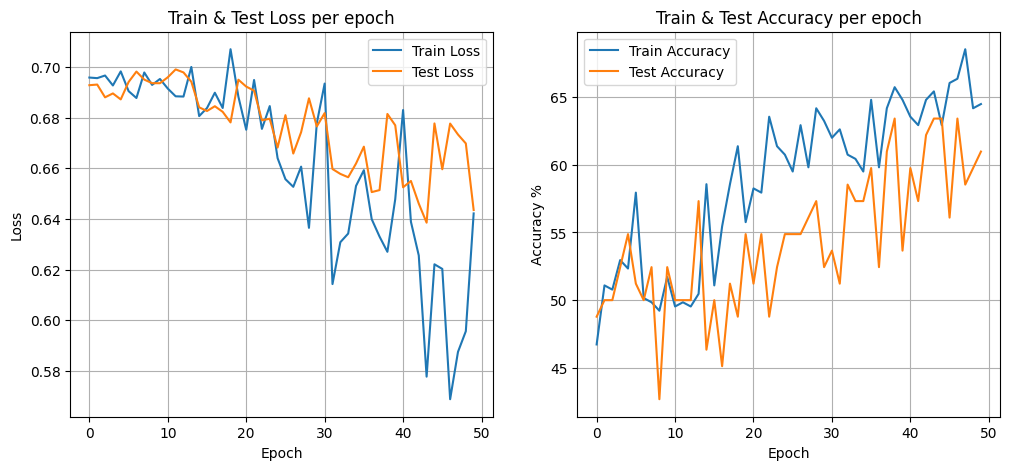

In [66]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [71]:
from torch.utils.data import Subset

In [72]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)